# Investigate a movie rental database
### In this project, I wrote SQL queries (Aggregation, Join, Subqueries, Common Table Expressions, Window Functions) to gain insights into the database and built visualizations to showcase the output of queries. 

(Note: this notebook was created for presentation purpose only. The SQL queries cannot be executed here. To run the queries, please follow the guideline in the README.md file)

## Question 1: Of all the family movies, which actor’s movie has been rented out the most?

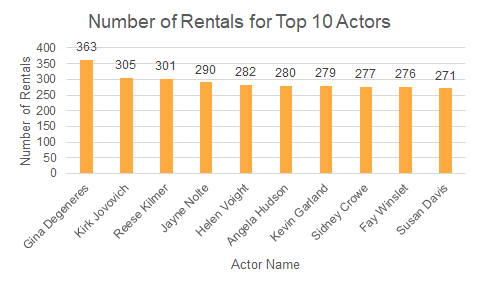

#### We can see that for family movies, the movies starring Gina Degeneres have the largest amount of rentals, which is 363.

```sql
/* Query 1 - query used for the 1st insight */

-- get film and rental ids which belong to family movies
WITH sub AS
	(SELECT
		f.film_id,
		r.rental_id
	FROM
		category c
		JOIN film_category fc ON c.category_id = fc.category_id
		JOIN film f ON fc.film_id = f.film_id
		JOIN inventory i ON f.film_id = i.film_id
		JOIN rental r ON i.inventory_id = r.inventory_id
	WHERE
		c.name IN ('Animation', 'Children', 'Classics', 'Comedy', 'Family', 'Music'))

-- get actor names and rental counts
SELECT
	CONCAT(a.first_name, ' ', a.last_name) AS actor_name,
	COUNT(sub.rental_id) AS number_rentals
FROM
	sub
	JOIN film_actor fa ON sub.film_id = fa.film_id
	JOIN actor a ON fa.actor_id = a.actor_id
GROUP BY
	1
ORDER BY
	2 DESC
LIMIT
	10;
```

## Question 2: What are the percentages of movies in the 4th quartile of rental durations for each family movie category?

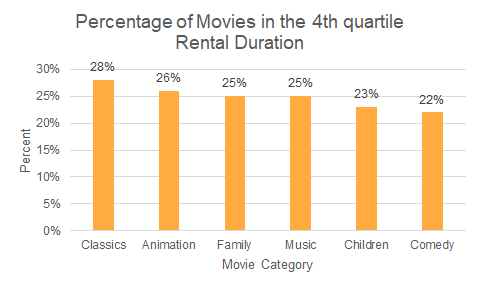

#### Within each family movie category, about a quarter of movies were rented out for the longest duration (4th quartile calculated over all movie categories). Among which the Classics movies have the largest percentage, 28%.

```sql
/* Query 2 - query used for the 2nd insight */

-- get the quartile of rental durations for all family movies
WITH tab1 AS
	(SELECT
		c.name AS category,
		f.rental_duration AS rental_duration,
		NTILE(4) OVER (ORDER BY f.rental_duration) AS duration_quartile
	FROM
		film f
		JOIN film_category fc ON f.film_id = fc.film_id
		JOIN category c ON c.category_id = fc.category_id
	WHERE
		c.name IN ('Animation', 'Children', 'Classics', 'Comedy', 'Family', 'Music')),
	-- count the number of movies in each quartile
	tab2 AS
	(SELECT
		category,
		duration_quartile,
		COUNT(*)
	FROM
		tab1
	GROUP BY
		1,
		2),
	-- count the total of movies within each category
	tab3 AS
	(SELECT
		*,
		SUM(count) OVER (PARTITION BY category ORDER BY category) AS sum
	FROM
		tab2)

-- calculate the percentage of movies for the 4th quartile
SELECT
	*,
	CAST(count/sum AS decimal(10,2)) AS percent
FROM
	tab3
where
	duration_quartile = 4
ORDER BY
	percent DESC;
```

## Question 3: For our top 10 paying customers, during which month they spent the most in 2007?

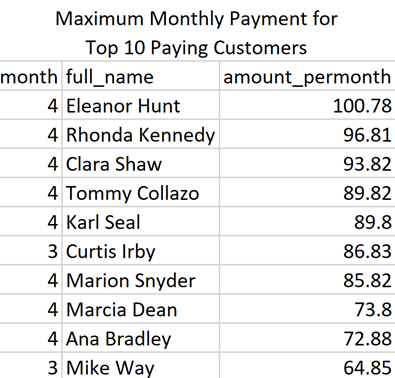

#### 8 of our top 10 paying customers spent the most in April. The rest 2 spent the most in March.

```sql
/* Query 3 - query used for the 3rd insight */

-- find the top 10 paying customers (names)
WITH sub1 AS
	(SELECT
		c.customer_id,
		SUM(p.amount) AS total_payment
	FROM
		customer c
		JOIN payment p ON c.customer_id = p.customer_id
	GROUP BY
		1
	ORDER BY
		2 DESC
	LIMIT
		10),
-- join with payment table to find more details about them
	sub2 AS
	(SELECT
		*
	FROM
		customer c
		JOIN payment p ON c.customer_id = p.customer_id
		JOIN sub1 ON c.customer_id = sub1.customer_id),
	-- calculate their monthly payments
	sub3 AS
	(SELECT
		DATE_TRUNC('month', payment_date) AS payment_month,
		CONCAT(first_name, ' ', last_name) AS full_name,
		SUM(amount) AS amount_permonth
	FROM
		sub2
	GROUP BY
		1,
		2),
	-- find out the maximum monthly payment for each person
	sub4 AS
	(SELECT
		full_name,
		MAX(amount_permonth) AS max_amount
	FROM
		sub3
	GROUP BY
		1)

-- get the month of the maximum monthly payment
SELECT
	EXTRACT (MONTH FROM sub3.payment_month) AS month,
	sub3.full_name,
	sub3.amount_permonth
FROM
	sub3
	JOIN sub4 ON sub3.amount_permonth = sub4.max_amount
ORDER BY
	sub3.amount_permonth DESC;
```

## Question 4: Of the top 10 paying customers, which customer paid the most difference between two successive months during the year?

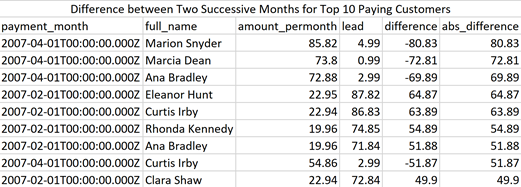

#### Based on the absolute difference between two successive months calculated here, the customer which paid the most difference is Marion Snyder, who paid \$80.83 less in May than in April.

```sql
/* Query 4 - query used for the 4th insight */

-- get the top 10 paying customers
WITH sub1 AS
	(SELECT
		c.customer_id,
		SUM(p.amount) AS total_payment
	FROM
		customer c
		JOIN payment p ON c.customer_id = p.customer_id
	GROUP BY
		1
	ORDER BY
		2 DESC
	LIMIT
		10),
	-- join with payment table to find more details about them
	sub2 AS
	(SELECT
		*
	FROM
		customer c
		JOIN payment p ON c.customer_id = p.customer_id
		JOIN sub1 ON c.customer_id = sub1.customer_id),
	-- find out the monthly payments for each customer
	sub3 AS
	(SELECT
		DATE_TRUNC('month', payment_date) AS payment_month,
		CONCAT(first_name, ' ', last_name) AS full_name,
		COUNT(payment_id) AS pay_count_permonth,
		SUM(amount) AS amount_permonth
	FROM
		sub2
	GROUP BY
		1,
		2)

-- calculate the (absolute) difference between two successive months
SELECT
	payment_month,
	full_name,
	amount_permonth,
	LEAD(amount_permonth) OVER (PARTITION BY full_name ORDER BY payment_month) AS lead,
	LEAD(amount_permonth) OVER (PARTITION BY full_name ORDER BY payment_month) - amount_permonth AS difference,
	ABS(LEAD(amount_permonth) OVER (PARTITION BY full_name ORDER BY payment_month) - amount_permonth) AS abs_difference
FROM
	sub3
ORDER BY
	abs_difference DESC NULLS LAST;
```